In [1]:
# from rgz_datamodules import RGZ_DataModule
from utils import Path_Handler
from rgz108k import RGZ108k 
from torch.utils.data import DataLoader
import torchvision.transforms as T

from matplotlib import pyplot as plt 

import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib as mpl

In [2]:
# Load the deduplicated DataFrame
df = pd.read_csv('hmc_rgz_deduplicated.csv')


In [3]:
#apply angular size cut off to dataframe
df_cut20 = df[df['las'] > 20]

In [4]:
df_cut20[df_cut20['Interval mean'] == 8 ].sort_values(by='Interval std', ascending=False)

,id,las,HMC RGZ,HMC RGZ std,Interval mean,Interval std,pred entropy,mutual info,radio.ra,radio.dec
34979,RGZJ134533.5+621107,116.102440,-9.735017,18.692194,8,6,0.682214,0.283763,206.389750,62.185301
6475,RGZJ162727.1+143627,97.002620,-9.560647,13.499609,8,5,0.658766,0.243382,246.862929,14.607772
40885,RGZJ170141.6+235741,118.544439,-10.585210,14.505547,8,5,0.675830,0.305144,255.423459,23.961507
57662,RGZJ161130.0+325826,117.864039,-9.758459,13.516835,8,5,0.688894,0.281781,242.875094,32.974165
86243,RGZJ105848.3+252342,93.442486,-9.487388,13.383630,8,5,0.645105,0.302263,164.721999,25.395623
93716,RGZJ161750.9+345556,104.671914,-8.429235,14.364888,8,5,0.655682,0.268499,244.461933,34.932343
79989,RGZJ110729.8+210600,30.134005,-9.496113,10.663819,8,4,0.664316,0.377398,166.874625,21.099846
85960,RGZJ135546.8+253423,129.424855,-9.248268,11.257689,8,4,0.691449,0.371564,208.944933,25.573094
324,RGZJ102832.0+231231,24.820409,-8.491942,9.776582,8,3,0.692238,0.206926,157.131873,23.207313


In [5]:
rgz_trainset_features_ft = pd.read_parquet('rgz_features_train_ft.parquet')
# rgz_testset_features_ft = pd.read_parquet('rgz_features_test_ft.parquet')

merged_df_train = pd.merge(df_cut20, rgz_trainset_features_ft, on='id', how='left')
# merged_df_test = pd.merge(df_cut20, rgz_testset_features_ft, on='id', how='left')

merged_df_train = merged_df_train.dropna()
# merged_df_test = merged_df_test.dropna()

In [6]:
#hyperpatameters for differetn fits
PCA_COMPONENTS = 200 #200

UMAP_N_NEIGHBOURS = 75
UMAP_MIN_DIST = 0.01
METRIC = "cosine"


discard_fraction = 0.3
seed = 69

In [7]:


pca = PCA(n_components=PCA_COMPONENTS, random_state=seed)
umap = UMAP(
    n_components=2,
    n_neighbors=UMAP_N_NEIGHBOURS,
    min_dist=UMAP_MIN_DIST,
    metric="cosine",
    random_state=seed,
)

In [8]:
train_features_ft = np.vstack(merged_df_train['features'])

In [9]:
# check if there are any NaN values in the features
merged_df_train['features'].isnull().sum()

0

In [10]:
# fit features to PCA and UMAP
pca.fit(train_features_ft)

umap.fit(pca.transform(train_features_ft))


# Transform the features using PCA and UMAP
pca_features = pca.transform(train_features_ft)

umap_features = umap.transform(pca_features)

/home/k22562dm/code/rgzeval/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
# Add the transformed features back to the dataframe

merged_df_train['umap_x'] = umap_features[:, 0]
merged_df_train['umap_y'] = umap_features[:, 1]

In [12]:
merged_df_train.isna().sum()

id               0
las              0
HMC RGZ          0
HMC RGZ std      0
Interval mean    0
Interval std     0
pred entropy     0
mutual info      0
radio.ra         0
radio.dec        0
features         0
umap_x           0
umap_y           0
dtype: int64

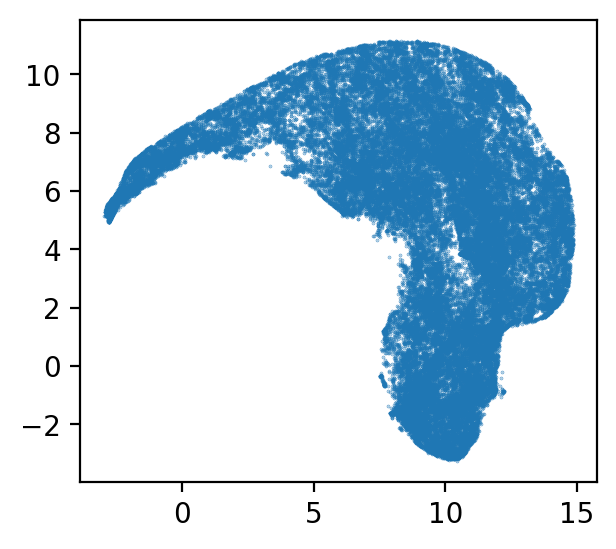

In [13]:
alpha = 0.6
marker_size = 0.1
fig_size = (10 / 3, 3)
fontsize = 9
marker = "o"

fig, ax = plt.subplots(dpi = 200)
fig.set_size_inches(fig_size)
scatter = ax.scatter(
    umap_features[:, 0],
    umap_features[:, 1],
    # c=reducer.targets,
    # cmap="Spectral",
    s=marker_size,
    marker=marker,
    # vmin=25,
    # vmax=100,
    alpha=alpha,
)

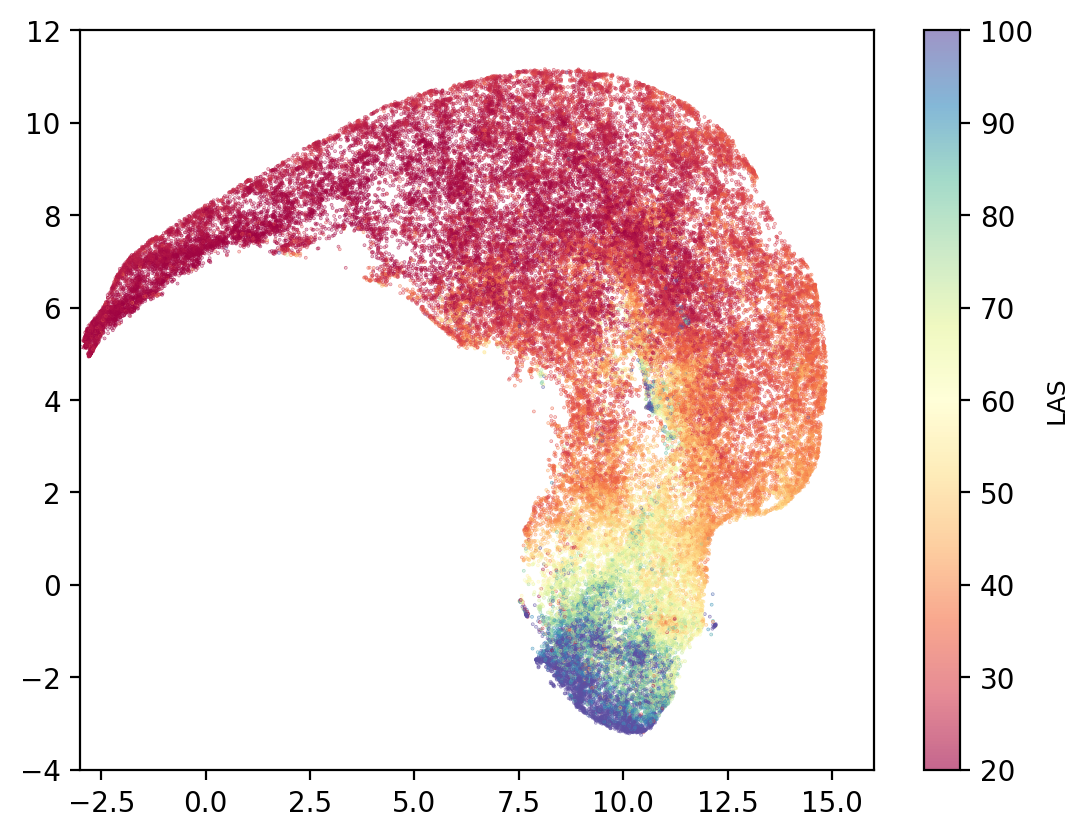

In [14]:
alpha = 0.6
marker_size = 0.1
fig_size = (10 / 3, 3)
fontsize = 9
marker = "o"

fig, ax = plt.subplots(dpi = 200)
# fig.set_size_inches(fig_size)
scatter = ax.scatter(
    merged_df_train['umap_x'].values,
    merged_df_train['umap_y'].values,
    
    c=merged_df_train['las'].values,
    cmap="Spectral",
    s=marker_size,
    marker=marker,
    vmin=20,
    vmax=100,
    alpha=alpha,
)
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("LAS", fontsize=fontsize)
plt.xlim(-3, 16)
plt.ylim(-4, 12)
plt.show()

In [15]:


def plot_umap_features(dataframe, choice, value, alpha=1.0, marker_size=0.1, fig_size=(10 / 3, 3), fontsize=9, marker="o"):
    """
    Plots UMAP features based on user-specified choice between 'Interval mean' and 'Interval std'.

    Parameters:
        dataframe (pd.DataFrame): The dataframe containing UMAP features and interval data.
        choice (str): Either 'Interval mean' or 'Interval std'.
        value (int): The specific value of the chosen interval to filter and plot.
        alpha (float): Transparency of the scatter points.
        marker_size (float): Size of the scatter points.
        fig_size (tuple): Size of the figure.
        fontsize (int): Font size for the plot.
        marker (str): Marker style for the scatter plot.
    """
    if choice not in ['Interval mean', 'Interval std']:
        raise ValueError("Choice must be either 'Interval mean' or 'Interval std'")

    cmap = mpl.colormaps["jet"]
    bounds = [1, 2, 3, 4, 5, 6, 7, 8] if choice == 'Interval mean' else [1, 2, 3, 4, 5, 6, 7]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

    fig, ax = plt.subplots(dpi=200)
    # fig.set_size_inches(fig_size)
    scatter = ax.scatter(
        dataframe['umap_x'][dataframe[choice] == value].values,
        dataframe['umap_y'][dataframe[choice] == value].values,
        c=dataframe[choice][dataframe[choice] == value].values,
        cmap=cmap,
        norm=norm,
        s=marker_size,
        marker=marker,
        alpha=alpha,
    )
    plt.colorbar(ax.scatter(dataframe['umap_x'][dataframe[choice] == value].values, 
                            dataframe['umap_y'][dataframe[choice] == value].values, 
                            s=marker_size, c = dataframe[choice][dataframe[choice] == value].values,
                            cmap = cmap, norm = norm, alpha=alpha))

    plt.xlim(-3, 16)
    plt.ylim(-4, 12)
    plt.show()

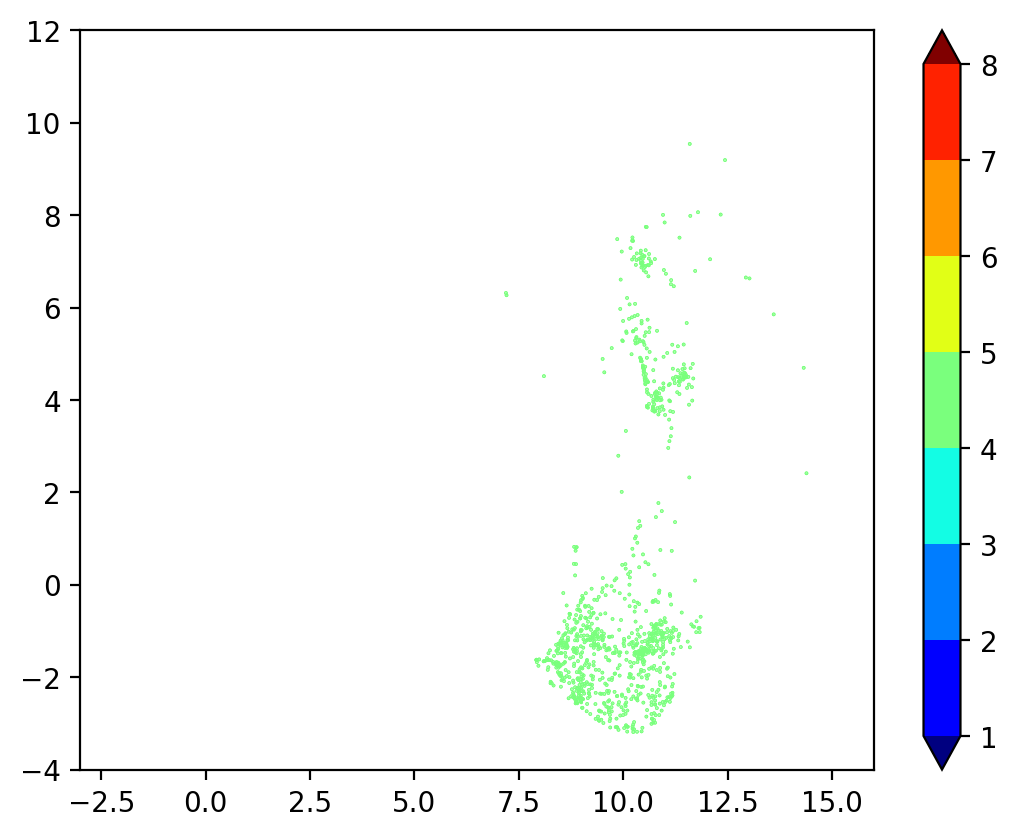

In [16]:
plot_umap_features(merged_df_train, 'Interval mean', 4)

In [17]:
#save calculated UMAP features to parquet file
merged_df_train.to_parquet('rgz_umap_features_train.parquet')

In [18]:
pd.read_parquet('rgz_umap_features_train.parquet').head()

,id,las,HMC RGZ,HMC RGZ std,Interval mean,Interval std,pred entropy,mutual info,radio.ra,radio.dec,features,umap_x,umap_y
0,RGZJ134541.2+232253,37.831507,-1.060241,5.297369,1,1,0.693147,2.980000e-08,206.422120,23.381925,"[0.4025808572769165, 0.6127355694770813, 0.997...",9.092141,4.852963
1,RGZJ105512.0+232306,37.364087,-1.164064,7.521431,1,2,0.693147,0.000000e+00,163.799660,23.384972,"[0.4113560914993286, 0.3947562575340271, 0.899...",10.588774,6.609107
2,RGZJ171515.3+232247,27.397689,-1.217391,5.540353,1,1,0.693147,2.980000e-08,258.815159,23.377849,"[0.554694652557373, 0.6984242796897888, 1.0905...",8.903749,6.047656
3,RGZJ091550.4+232254,20.129228,-1.044939,5.665369,1,1,0.676335,2.907447e-01,138.960429,23.381641,"[0.7309891581535339, 0.7256085276603699, 0.907...",6.804275,8.738637
4,RGZJ130402.8+232301,24.191293,-1.372522,4.413287,1,2,0.659026,3.034060e-01,196.011873,23.383691,"[0.4660899341106415, 0.8661344647407532, 0.886...",6.860055,5.906828
